In [ ]:
#Importando bibliotecas necessárias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import locale
import openpyxl
from scipy import stats
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

import seaborn as sns
rcParams['figure.figsize'] = 10, 5
sns.set_style('whitegrid')
import warnings
warnings.simplefilter("ignore")

In [ ]:
#Entrada de dados
Dados = pd.read_excel('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/RioDeJaneiro.xlsx')
Dados = Dados.drop(Dados.index[[619, 620,621]])
Dados['Data'] = pd.to_datetime(Dados['Data'], dayfirst=True, errors='coerce')
Dados['Consumo Medio Hectare (l/ha)'] = (Dados['Consumo (l)']/Dados['Área Operacional (ha)']).replace([np.inf, -np.inf], 0)
Dados = Dados.fillna(0)

#Renomear coluna operador e talhão
Dados.loc[Dados.Operador=='101111 - Francisco','Operador']='A'
Dados.loc[Dados.Operador=='101274 - FERNANDO','Operador']='B'
Dados.loc[Dados['FZT']=='8 - 1 - 4','FZT']='RA4'
Dados.loc[Dados['FZT']=='8 - 1 - 5','FZT']='RA5'
Dados.loc[Dados['FZT']=='8 - 1 - 6','FZT']='RA6'

# #Adicionando coluna para largura de trabalho
Dados['Largura de trabalho (m)'] = 22.5

# #Filtro para dados do talhão, processo e estado operacional da máquina
Dados = Dados[(Dados['Processo']=='190 - PLANTIO DE SOJA')].reset_index(drop=True)

indexNames = Dados[ (Dados['Estado'] == 'TRABALHANDO')
               & (Dados['Área Operacional (ha)'] == 0.0) ].index
Dados = Dados.drop(indexNames , inplace=False)

Dados1 = Dados[(Dados['FZT'] == 'RA4') | (Dados['FZT'] == 'RA5') | (Dados['FZT'] == 'RA6')].reset_index(drop=True)
Dados2 = Dados1[(Dados1['Estado'] != 'TRABALHANDO')].reset_index(drop=True)
Dados3 = Dados1[(Dados1['Estado'] == 'TRABALHANDO')].reset_index(drop=True)
Dados3 = Dados3.drop(0).reset_index(drop=True)
Dados1.head(3)

,Data,Hora,Unidade,FZT,Equipamento,Cód. Implemento,Equipe,Operador,Processo,Operação,Estado,Área Operacional (ha),Tempo (h),Motor Ligado (h),Consumo (l),Consumo Médio (l/h),Consumo Medio Hectare (l/ha),Velocidade Média (km/h),RPM Média,Largura de trabalho (m)
0,2021-11-02,08:00,ORQUÍDEAS/MANGAS/SÃO VICENTE,RA4,51 - TRATOR JOHN DEERE 9620R,1013.0,SCHMIDT,B,190 - PLANTIO DE SOJA,DESLOCAMENTO,DESLOCAMENTO,0.0,0.009167,0.009167,0.297650,32.470909,0.0,4.83,1458.91,22.5
1,2021-11-02,08:00,ORQUÍDEAS/MANGAS/SÃO VICENTE,RA4,51 - TRATOR JOHN DEERE 9620R,1013.0,SCHMIDT,B,190 - PLANTIO DE SOJA,MANOBRA,MANOBRA,0.0,0.077500,0.077500,1.878119,24.233799,0.0,3.81,1293.63,22.5
2,2021-11-02,08:00,ORQUÍDEAS/MANGAS/SÃO VICENTE,RA4,51 - TRATOR JOHN DEERE 9620R,1013.0,SCHMIDT,B,190 - PLANTIO DE SOJA,MANUTENCAO MECANICA,PARADA,0.0,0.144167,0.144167,1.768925,12.270000,0.0,0.04,900.00,22.5


In [ ]:
#Analisando motivos de paradas
Paradas = round((Dados1.groupby('Data')['Operação', 'Tempo (h)'].count().reset_index()),2)
Paradas

,Data,Operação,Tempo (h)
0,2021-11-02,94,94
1,2021-11-03,119,119
2,2021-11-04,81,81


In [ ]:
#Cálculos de desempenho
Dados3['CcT (ha/h)'] = (Dados3['Largura de trabalho (m)'] * ((Dados3['Velocidade Média (km/h)']*1000)/10000))
Dados3['CcE (ha/h)'] = Dados3['Área Operacional (ha)'] / Dados3['Tempo (h)']
Dados3['CcO (ha/h)'] = (Dados3['Área Operacional (ha)'].sum()) / (Dados1['Tempo (h)'].sum())
Dados3['EC (%)'] = (Dados3['CcE (ha/h)']/Dados3['CcT (ha/h)']) * 100
Dados3['RcT (%)'] = (Dados3['CcE (ha/h)'] / Dados3['CcT (ha/h)']) * 100
Dados3['RcE (%)'] = (Dados3['CcO (ha/h)'] / Dados3['CcE (ha/h)']) * 100
Dados3['Distancia Percorrida (m)'] = (Dados3['Velocidade Média (km/h)']*1000) * (Dados3['Tempo (h)'])
Dados3['ET (%)'] = ((Dados3['Área Operacional (ha)'] * 10000) / (Dados3['Distancia Percorrida (m)'] * Dados3['Largura de trabalho (m)'])) * 100

#Remover outliers
indexNames1 = Dados3[(Dados3['Operador'] == 'A')
               & (Dados3['Velocidade Média (km/h)'] < 9)].index
Dados3 = Dados3.drop(indexNames1 , inplace=False)
Dados3.head(3)

,Data,Hora,Unidade,FZT,Equipamento,Cód. Implemento,Equipe,Operador,Processo,Operação,...,RPM Média,Largura de trabalho (m),CcT (ha/h),CcE (ha/h),CcO (ha/h),EC (%),RcT (%),RcE (%),Distancia Percorrida (m),ET (%)
0,2021-11-02,09:00,ORQUÍDEAS/MANGAS/SÃO VICENTE,RA4,51 - TRATOR JOHN DEERE 9620R,1013.0,SCHMIDT,B,190 - PLANTIO DE SOJA,PLANTIO DE SOJA,...,1787.11,22.5,25.4025,24.934530,8.783883,98.157781,98.157781,35.227785,837.341667,98.157781
1,2021-11-02,09:00,ORQUÍDEAS/MANGAS/SÃO VICENTE,RA5,51 - TRATOR JOHN DEERE 9620R,1013.0,SCHMIDT,B,190 - PLANTIO DE SOJA,PLANTIO DE SOJA,...,1910.17,22.5,24.8175,24.117201,8.783883,97.178203,97.178203,36.421651,2025.230555,97.178203
2,2021-11-02,09:00,ORQUÍDEAS/MANGAS/SÃO VICENTE,RA6,51 - TRATOR JOHN DEERE 9620R,1013.0,SCHMIDT,B,190 - PLANTIO DE SOJA,PLANTIO DE SOJA,...,1886.14,22.5,23.7825,23.031495,8.783883,96.842196,96.842196,38.138569,672.369444,96.842196


In [ ]:
dfff = [['A', 9.090168340786398], ['B', 8.197358023995543]]
Tab = pd.DataFrame(dfff, columns=['Operador', 'CcO (ha/h)'])
df_mean = round((Dados3.groupby('Operador')['CcT (ha/h)', 'CcE (ha/h)'].mean().reset_index()),2)
df_mean['CcO (ha/h)'] = Tab['CcO (ha/h)']
df_mean.to_excel('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/Tabela Médias.xlsx', index = False)

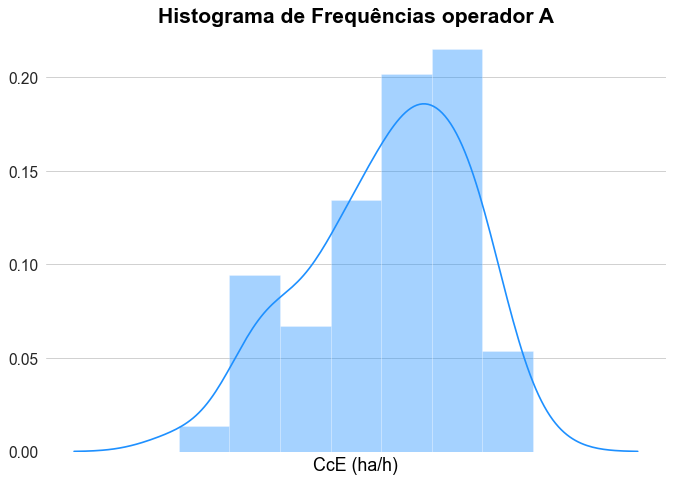

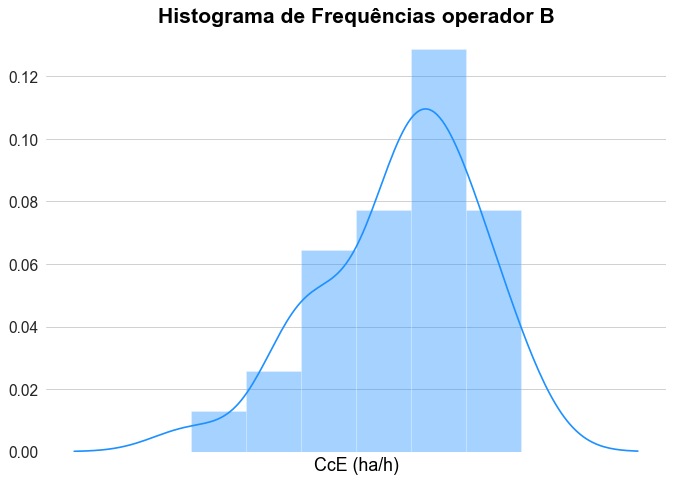

In [ ]:
#Histograma de frequência para CcE
DadosA = Dados3[Dados3['Operador']=='A']
DadosB = Dados3[Dados3['Operador']=='B']
DadosA = DadosA[['CcE (ha/h)']]
DadosB = DadosB[['CcE (ha/h)']]

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(DadosA, color="dodgerblue", label="Compact",)
plt.ylabel('', size = 16, fontweight='bold', color='black', alpha=1)
plt.xlabel('CcE (ha/h)', size = 16, color='black', alpha=1)
plt.title('Histograma de Frequências operador A', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.xticks([])
plt.yticks(rotation=0, fontsize=14)
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/Histograma de Frequências operador A.png', format='png')
plt.show()

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(DadosB, color="dodgerblue", label="Compact",)
plt.ylabel('', size = 16, fontweight='bold', color='black', alpha=1)
plt.xlabel('CcE (ha/h)', size = 16, color='black', alpha=1)
plt.title('Histograma de Frequências operador B', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.xticks([])
plt.yticks(rotation=0, fontsize=14)
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/Histograma de Frequências operador B.png', format='png')
plt.show()

In [ ]:
#Estatística descritiva dos dados
A = pd.DataFrame(DadosA.describe()).reset_index()
B = pd.DataFrame(DadosB.describe()).reset_index()
A['CcE (ha/h) (b)'] = B['CcE (ha/h)']
df = A.rename(columns={'CcE (ha/h)': 'CcE (ha/h) (a)'})
df = df.set_index('index')
df

,CcE (ha/h) (a),CcE (ha/h) (b)
index,,
count,58.000000,30.000000
mean,26.085056,22.828113
std,1.992033,3.625551
min,20.798048,12.960450
25%,24.817888,20.987886
50%,26.463756,23.480176
75%,27.595234,25.291948
max,29.771580,28.488806


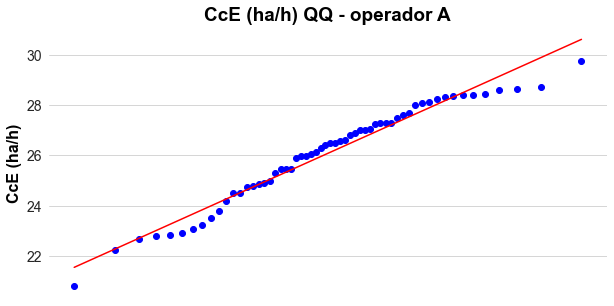

In [ ]:
#Identificar outliers de CcE com QQ para operador A
stats.probplot(DadosA['CcE (ha/h)'], dist="norm", plot=plt)
plt.ylabel('CcE (ha/h)', size = 16, fontweight='bold', color='black', alpha=1)
plt.xlabel('', size = 16, fontweight='bold', color='black', alpha=1)
plt.title('CcE (ha/h) QQ - operador A', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.xticks([])
plt.yticks(rotation=0, fontsize=14)
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/CcE QQ operador A.png', format='png')
plt.show()

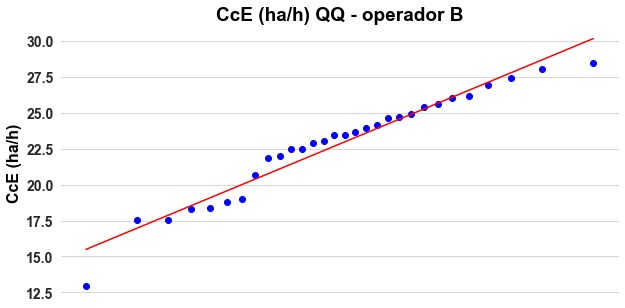

In [ ]:
#Identificar outliers de CcE com QQ para operador B
stats.probplot(DadosB['CcE (ha/h)'], dist="norm", plot=plt)
plt.ylabel('CcE (ha/h)', size = 16, fontweight='bold', color='black', alpha=1)
plt.xlabel('', size = 16, fontweight='bold', color='black', alpha=1)
plt.title('CcE (ha/h) QQ - operador B', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.xticks([])
plt.yticks(rotation=0, fontsize=14, fontweight='bold')
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/CcE QQ operador B.png', format='png')
plt.show()

In [ ]:
#Teste t para médias independentes operador A
stats.shapiro(DadosA['CcE (ha/h)'])

ShapiroResult(statistic=0.962044894695282, pvalue=0.0668511688709259)

In [ ]:
#Teste t para médias independentes operador B
stats.shapiro(DadosB['CcE (ha/h)'])

ShapiroResult(statistic=0.951160728931427, pvalue=0.18159087002277374)

In [ ]:
#Comprovando o teste T para médias com outra função integrando os dois operadores

'''Os testes t para duas amostras podem ser realizados para amostras independentes ou pareadas
por meio das funções ttest_ind e ttest_rel, respectivamente. A função ttest_ind recebe dois
arrays e realiza um teste bicaudal para igualdade das duas médias'''

print(
    'Não rejeita a hipótese nula: {}'.format(stats.ttest_ind(DadosA['CcE (ha/h)'], DadosB['CcE (ha/h)']))
)

Não rejeita a hipótese nula: Ttest_indResult(statistic=5.44956625560066, pvalue=4.741264487452342e-07)


In [ ]:
# Teste F para variâncias

'''A função ttest_ind assume por padrão que as duas populações têm a mesma variância'''

print(
    'Rejeita a hipótese nula: {}'.format(
        stats.ttest_ind_from_stats(
            (DadosA['CcE (ha/h)'].mean()), (DadosA['CcE (ha/h)'].std()), (len(DadosA['CcE (ha/h)'])),
            (DadosB['CcE (ha/h)'].mean()), (DadosB['CcE (ha/h)'].std()), (len(DadosB['CcE (ha/h)'])),
            equal_var=False
        )
    )
)

Rejeita a hipótese nula: Ttest_indResult(statistic=4.576040367250503, pvalue=4.8783119760454446e-05)


In [ ]:
#Verificando alguns dados
OpAG = Dados1[Dados1['Operador']=='A']
OpBG = Dados1[Dados1['Operador']=='B']
OpA = Dados3[Dados3['Operador']=='A']
OpB = Dados3[Dados3['Operador']=='B']
print("Operador - A - ", list(OpA['Data'].unique()))
print("Operador - B - ", list(OpB['Data'].unique()))
OpAA = Dados2[Dados2['Operador']=='A']
Manobra1 = OpAA[OpAA['Operação']=='MANOBRA']
OpBB = Dados2[Dados2['Operador']=='B']
Manobra2 = OpBB[OpBB['Operação']=='MANOBRA']
print("Manobra A - ", (Manobra1['Tempo (h)'].mean()*3600))
print("Manobra B - ", (Manobra2['Tempo (h)'].mean()*3600))
OpA['CCO'] = (OpA['Área Operacional (ha)'].sum()) / (OpAG['Tempo (h)'].sum())
OpB['CCO'] = (OpB['Área Operacional (ha)'].sum()) / (OpBG['Tempo (h)'].sum())
print("CcO A - ", OpA['CCO'].mean())
print("CcO B - ", OpB['CCO'].mean())
Dados3.loc[Dados3['Operador'] == 'A', 'Tempo médio de manobras (min)'] = (Manobra1['Tempo (h)'].mean()*60)
Dados3.loc[Dados3['Operador'] == 'B', 'Tempo médio de manobras (min)'] = (Manobra2['Tempo (h)'].mean()*60)
Dados3.loc[Dados3['Operador'] == 'A', 'Qtd. manobras'] = round(len(Manobra1['Tempo (h)']))
Dados3.loc[Dados3['Operador'] == 'B', 'Qtd. manobras'] = round(len(Manobra2['Tempo (h)']))
print(len(OpA), len(OpB))

Operador - A -  [numpy.datetime64('2021-11-02T00:00:00.000000000'), numpy.datetime64('2021-11-03T00:00:00.000000000'), numpy.datetime64('2021-11-04T00:00:00.000000000')]
Operador - B -  [numpy.datetime64('2021-11-02T00:00:00.000000000'), numpy.datetime64('2021-11-03T00:00:00.000000000'), numpy.datetime64('2021-11-04T00:00:00.000000000')]
Manobra A -  103.86792451698116
Manobra B -  68.3846153446154
CcO A -  9.090168340786398
CcO B -  8.197358023995543
58 30


In [ ]:
#Analisando motivos de paradas
#Operador A
ParadasA = round((OpAG.groupby('Operação')['Tempo (h)'].sum().reset_index()),2)
CountA = round((OpAG.groupby('Operação')['Tempo (h)'].count().reset_index()),2)
ParadasA['Apontamentos'] = CountA['Tempo (h)']
ParadasA = ParadasA.rename({'Tempo (h)':'Tempo (h) A', 'Apontamentos': 'Apontamentos A'}, axis=1, inplace=False)
#Operador B
ParadasB = round((OpBG.groupby('Operação')['Tempo (h)'].sum().reset_index()),2)
CountB = round((OpBG.groupby('Operação')['Tempo (h)'].count().reset_index()),2)
ParadasB['Apontamentos'] = CountB['Tempo (h)']
ParadasB = ParadasB.rename({'Tempo (h)':'Tempo (h) B', 'Apontamentos': 'Apontamentos B'}, axis=1, inplace=False)

ParadasA['Tempo (h) B'] = ParadasB['Tempo (h) B']
ParadasA['Apontamentos B'] = ParadasB['Apontamentos B']
ParadasA

,Operação,Tempo (h) A,Apontamentos A,Tempo (h) B,Apontamentos B
0,ABASTECIMENTO DE COMBUSTIVEL,0.66,2,0.72,1
1,ABASTECIMENTO DE INSUMOS,1.37,3,0.78,2
2,BANHEIRO,0.07,1,6.11,7
3,CONDICOES CLIMATICAS,12.54,15,0.13,5
4,DESLOCAMENTO,0.77,10,0.02,1
5,FINAL DE EXPEDIENTE,0.01,2,0.61,1
6,LIMPEZA DE DISCOS/BOTINHAS,5.88,36,0.02,1
7,MANOBRA,1.53,53,1.14,10
8,MANUTENCAO INICIAL/CHECK LIST,0.04,1,0.49,26
9,MANUTENCAO MECANICA,1.16,4,1.38,4


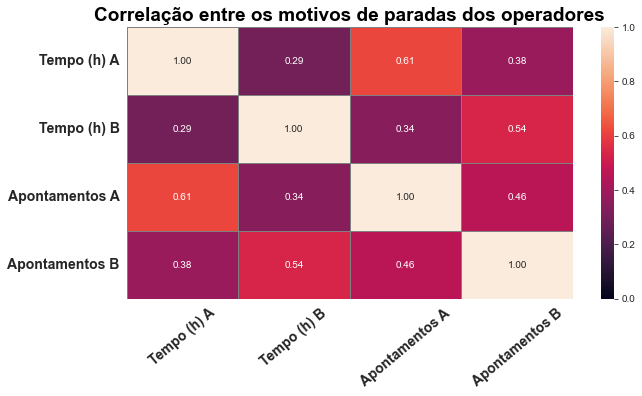

In [ ]:
# Correlação entre os motivos de paradas dos operadores
ParadasA = ParadasA[['Tempo (h) A', 'Tempo (h) B', 'Apontamentos A', 'Apontamentos B']]
ParadasA = ParadasA.corr()

p = sns.heatmap(data=ParadasA, annot=True, fmt=".2f", linewidths=.5, linecolor='gray', vmin=0, vmax=1, square=False)
plt.title('Correlação entre os motivos de paradas dos operadores', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=True)
plt.xticks(rotation=40, fontsize=14, fontweight='bold')
plt.yticks(rotation=0, fontsize=14, fontweight='bold')
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/Correlação.png', format='png')

In [ ]:
# Filtros para gráfico da realização operacional
AreaOp = round((Dados3.groupby('Operador')['Área Operacional (ha)'].sum().reset_index()),2)
Time = round((Dados3.groupby('Operador')['Tempo (h)'].sum().reset_index()),2)
Consumo = round((Dados3.groupby('Operador')['Consumo Medio Hectare (l/ha)'].mean().reset_index()),2)
Velocidade = round((Dados3.groupby('Operador')['Velocidade Média (km/h)'].mean().reset_index()),2)
Rpm = round((Dados3.groupby('Operador')['RPM Média'].mean().reset_index()),2)
result = AreaOp.merge(Time,on='Operador', how='left').merge(Consumo,on='Operador', how='left').merge(Velocidade,on='Operador', how='left').merge(Rpm,on='Operador', how='left')
result= result.set_index('Operador')
result['RPM Média'] = result['RPM Média']/10
result

,Área Operacional (ha),Tempo (h),Consumo Medio Hectare (l/ha),Velocidade Média (km/h),RPM Média
Operador,,,,,
A,339.11,13.04,4.07,11.98,190.986
B,153.96,6.53,4.31,10.48,191.913


<Figure size 720x360 with 0 Axes>

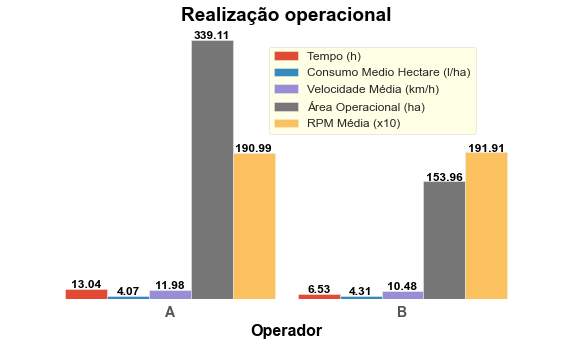

In [ ]:
#Gráfico realização operacional
AreaOp = round((Dados3.groupby('Operador')['Área Operacional (ha)'].sum().reset_index()),2)
Time = round((Dados3.groupby('Operador')['Tempo (h)'].sum().reset_index()),2)
Consumo = round((Dados3.groupby('Operador')['Consumo Medio Hectare (l/ha)'].mean().reset_index()),2)
Velocidade = round((Dados3.groupby('Operador')['Velocidade Média (km/h)'].mean().reset_index()),2)
Rpm = round((Dados3.groupby('Operador')['RPM Média'].mean().reset_index()),2)
result = AreaOp.merge(Time,on='Operador', how='left').merge(Consumo,on='Operador', how='left').merge(Velocidade,on='Operador', how='left').merge(Rpm,on='Operador', how='left')
result= result.set_index('Operador')
result['RPM Média (x10)'] = result['RPM Média']/10
result = result.drop(columns=['RPM Média'])
result = result[['Tempo (h)', 'Consumo Medio Hectare (l/ha)', 'Velocidade Média (km/h)', 'Área Operacional (ha)', 'RPM Média (x10)']]

fig3 = plt.figure()
plt.style.use("ggplot")
result.plot(kind='bar', width=0.9)
for i, v in enumerate(result['Tempo (h)']):
            plt.text(i  - 0.36, v + 1, str(v), color='black', ha='center', size = 12,  fontweight='bold', alpha=1)
for j, t in enumerate(result['Consumo Medio Hectare (l/ha)']):
            plt.text(j  - 0.18, t + 1, str(t), color='black', ha='center', size = 12, fontweight='bold', alpha=1)
for k, u in enumerate(result['Velocidade Média (km/h)']):
            plt.text(k  + 0, u + 1, str(u), color='black', ha='center', size = 12, fontweight='bold', alpha=1)
for w, x in enumerate(result['Área Operacional (ha)']):
            plt.text(w  + 0.18, x + 1, str(x), color='black', ha='center', size = 12, fontweight='bold', alpha=1)
for l, o in enumerate(result['RPM Média (x10)'].round(2)):
            plt.text(l  + 0.36, o + 1, str(o), color='black', ha='center', size = 12, fontweight='bold', alpha=1)
plt.xlabel('Operador', size = 16, fontweight='bold', color='black', alpha=1)
plt.title('Realização operacional', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.yticks([])
plt.xticks(rotation=0, fontsize=14, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(0.85, 0.95), fontsize=12, facecolor='lightyellow')
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/Realização operacional At.png', format='png')
plt.show()

In [ ]:
# Tratando dados para gráfico de eficiência de trajeto por dia
ET_dia = round((Dados3.groupby('Data')['ET (%)'].mean().reset_index()),2)
ET_dia['Data'] = ET_dia['Data'].dt.strftime('%d/%m/%Y')
ET_dia['Área Operacional (ha)'] = round((Dados3.groupby('Data')['Área Operacional (ha)'].sum().reset_index().iloc[:,1]),2)
ET_dia['Distancia Percorrida (km)'] = round(((Dados3.groupby('Data')['Distancia Percorrida (m)'].sum().reset_index().iloc[:,1])/1000), 2)
ET_dia

,Data,ET (%),Área Operacional (ha),Distancia Percorrida (km)
0,02/11/2021,96.62,163.94,75.39
1,03/11/2021,96.65,178.27,81.74
2,04/11/2021,96.93,150.86,69.12


<Figure size 720x360 with 0 Axes>

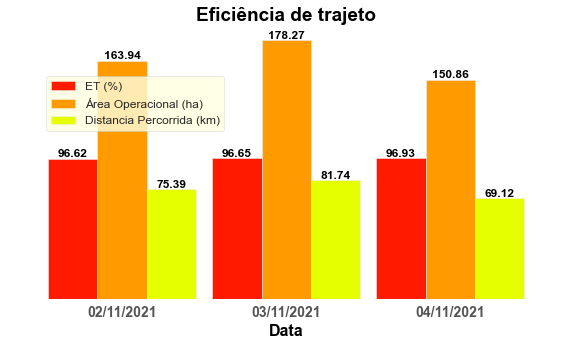

In [ ]:
#Gráfico eficiência de trajeto/dia
result = ET_dia.set_index('Data')

fig5 = plt.figure()
plt.style.use("ggplot")
result.plot(kind='bar', width=0.9, color=['#FF1A00', '#FF9A00', '#E5FF00'])
for i, v in enumerate(result['ET (%)']):
            plt.text(i  - 0.3, v + 1, str(v), color='black', ha='center', size = 12,  fontweight='bold', alpha=1)
for j, t in enumerate(result['Área Operacional (ha)']):
            plt.text(j  - 0, t + 1, str(t), color='black', ha='center', size = 12, fontweight='bold', alpha=1)
for k, u in enumerate(result['Distancia Percorrida (km)']):
            plt.text(k  + 0.3, u + 1, str(u), color='black', ha='center', size = 12, fontweight='bold', alpha=1)

plt.xlabel('Data', size = 16, fontweight='bold', color='black', alpha=1)
plt.title('Eficiência de trajeto', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.yticks([])
plt.xticks(rotation=0, fontsize=14, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(0.40, 0.84), fontsize=12, facecolor='lightyellow')
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/Eficiência de trajeto Data.png', format='png')
plt.show()

In [ ]:
# Tratando dados para eficiência de trajeto por operador
Manobraa = Dados2[Dados2['Estado']=='MANOBRA']
Manobraa['Distancia percorrida em manobra (km)'] = (Manobraa['Velocidade Média (km/h)'] * Manobraa['Tempo (h)']).round(2).replace([np.inf, -np.inf], 0)
Dist_manobra = (Manobraa.groupby('Operador')['Distancia percorrida em manobra (km)'].sum().reset_index())
ET_dia1 = round((Dados3.groupby('Operador')['ET (%)'].mean().reset_index()),2)
ET_dia1['Área Operacional (ha)'] = round((Dados3.groupby('Operador')['Área Operacional (ha)'].sum().reset_index().iloc[:,1]),2)
ET_dia1['Distancia Percorrida (km)'] = round(((Dados3.groupby('Operador')['Distancia Percorrida (m)'].sum().reset_index().iloc[:,1])/1000), 2)
ET_dia1['Distancia percorrida em manobra (km)'] = Dist_manobra['Distancia percorrida em manobra (km)']
ET_dia1

,Operador,ET (%),Área Operacional (ha),Distancia Percorrida (km),Distancia percorrida em manobra (km)
0,A,96.73,339.11,155.75,3.17
1,B,96.69,153.96,70.49,1.67


<Figure size 720x360 with 0 Axes>

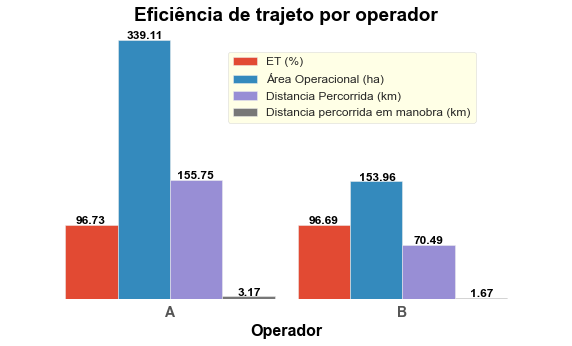

In [ ]:
#Gráfico eficiência de trajeto/operador
result = ET_dia1.set_index('Operador')

fig4 = plt.figure()
plt.style.use("ggplot")
result.plot(kind='bar', width=0.9)
for i, v in enumerate(result['ET (%)']):
            plt.text(i  - 0.34, v + 1, str(v), color='black', ha='center', size = 12,  fontweight='bold', alpha=1)
for j, t in enumerate(result['Área Operacional (ha)']):
            plt.text(j  - 0.11, t + 1, str(t), color='black', ha='center', size = 12, fontweight='bold', alpha=1)
for k, u in enumerate(result['Distancia Percorrida (km)']):
            plt.text(k  + 0.11, u + 1, str(u), color='black', ha='center', size = 12, fontweight='bold', alpha=1)
for q, w in enumerate(result['Distancia percorrida em manobra (km)']):
            plt.text(q  + 0.34, w + 1, str(w), color='black', ha='center', size = 12,  fontweight='bold', alpha=1)

plt.xlabel('Operador', size = 16, fontweight='bold', color='black', alpha=1)
plt.title('Eficiência de trajeto por operador', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.yticks([])
plt.xticks(rotation=0, fontsize=14, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(0.85, 0.93), fontsize=12, facecolor='lightyellow')
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/Eficiência de trajeto Operador.png', format='png')
plt.show()

<Figure size 720x360 with 0 Axes>

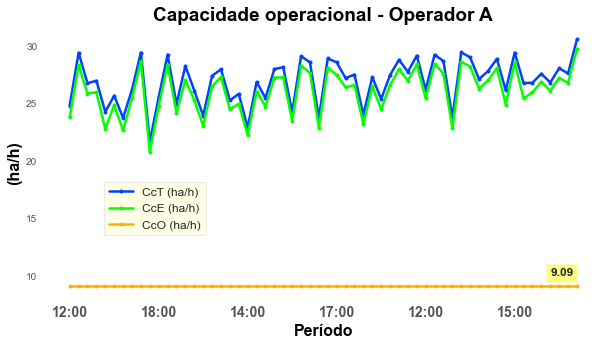

In [ ]:
# Gráfico da capacidade operacional - Operador A sem velocidade
Dados3['Tempo trabalhando (min)'] = Dados3['Tempo (h)']*60
Capacidades1 = Dados3[['Hora', 'Operador','CcT (ha/h)', 'CcE (ha/h)', 'CcO (ha/h)']]
Capacidades1['CcO (ha/h)'] = OpA['CCO'].mean()
Capacidades1 = Capacidades1.set_index('Hora')
CapacidadesA = Capacidades1[Capacidades1['Operador']=='A']

fig4 = plt.figure()
plt.style.use("ggplot")
CapacidadesA.plot(color=['#0042FF', '#04FF00', '#FFAE00', '#04FF00'], linestyle='-', marker='.', lw=2.5)
plt.xlabel('Período', size = 16, fontweight='bold', color='black', alpha=1)
plt.ylabel('(ha/h)', size = 16, fontweight='bold', color='black', alpha=1)
plt.title('Capacidade operacional - Operador A', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.xticks(rotation=0, fontsize=14, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(0.30, 0.45), fontsize=12, facecolor='lightyellow')
plt.text(54, ((OpA['CCO'].mean())+.9), str(round((OpA['CCO'].mean()),2)), size=12, fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.5))
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/CapacidadeOpA.png', format='png')
plt.show()

<Figure size 720x360 with 0 Axes>

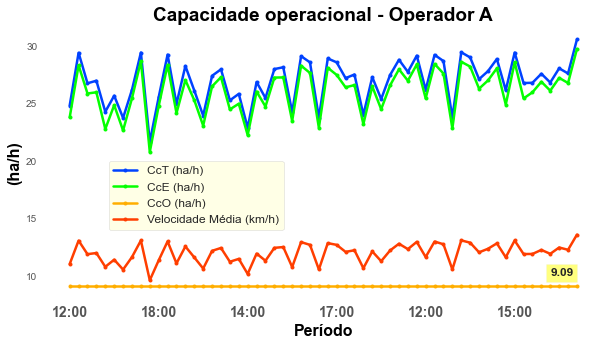

In [ ]:
# Gráfico da capacidade operacional - Operador A com velocidade
Dados3['Tempo trabalhando (min)'] = Dados3['Tempo (h)']*60
Capacidades1 = Dados3[['Hora', 'Operador','CcT (ha/h)', 'CcE (ha/h)', 'CcO (ha/h)', 'Velocidade Média (km/h)']]
Capacidades1['CcO (ha/h)'] = OpA['CCO'].mean()
Capacidades1 = Capacidades1.set_index('Hora')
CapacidadesA = Capacidades1[Capacidades1['Operador']=='A']

fig4 = plt.figure()
plt.style.use("ggplot")
CapacidadesA.plot(color=['#0042FF', '#04FF00', '#FFAE00', '#FF3E00', '#00D4FF'], linestyle='-', marker='.', lw=2.5)
plt.xlabel('Período', size = 16, fontweight='bold', color='black', alpha=1)
plt.ylabel('(ha/h)', size = 16, fontweight='bold', color='black', alpha=1)
plt.title('Capacidade operacional - Operador A', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.xticks(rotation=0, fontsize=14, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(.44, 0.53), fontsize=12, facecolor='lightyellow')
plt.text(54, ((OpA['CCO'].mean())+.9), str(round((OpA['CCO'].mean()),2)), size=12, fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.5))
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/CapacidadeOpA_V.png', format='png')
plt.show()

<Figure size 720x360 with 0 Axes>

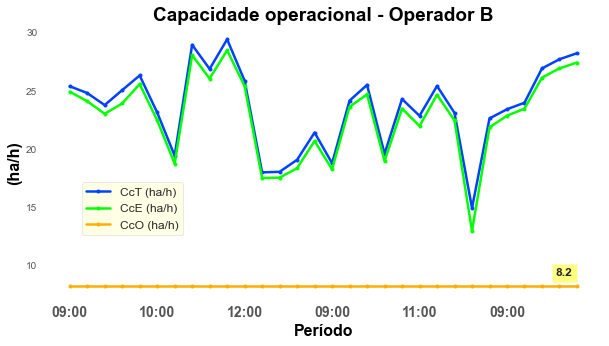

In [ ]:
# Gráfico da capacidade operacional - Operador A sem velocidade
Capacidades2 = Dados3[['Hora', 'Operador','CcT (ha/h)', 'CcE (ha/h)', 'CcO (ha/h)']]
Capacidades2['CcO (ha/h)'] = OpB['CCO'].mean()
Capacidades2 = Capacidades2.set_index('Hora')
CapacidadesB = Capacidades2[Capacidades2['Operador']=='B']

fig11 = plt.figure()
plt.style.use("ggplot")
CapacidadesB.plot(color=['#0042FF', '#04FF00', '#FFAE00', '#FF3E00'], linestyle='-', marker='.', lw=2.5)
plt.xlabel('Período', size = 16, fontweight='bold', color='black', alpha=1)
plt.ylabel('(ha/h)', size = 16, fontweight='bold', color='black', alpha=1)
plt.title('Capacidade operacional - Operador B', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.xticks(rotation=0, fontsize=14, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(0.26, 0.45), fontsize=12, facecolor='lightyellow')
plt.text(27.8, ((OpB['CCO'].mean())+.9), str(round((OpB['CCO'].mean()),2)), size=12, fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.5))
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/CapacidadeOpB.png', format='png')
plt.show()

<Figure size 720x360 with 0 Axes>

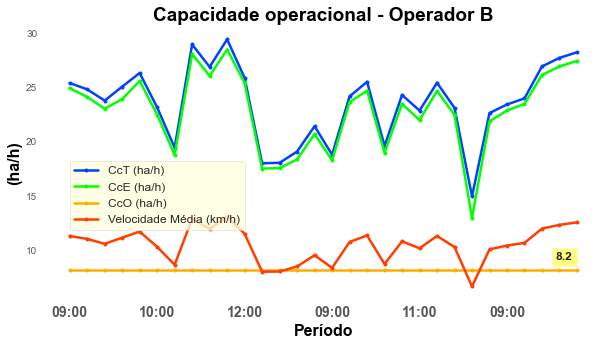

In [ ]:
# Gráfico da capacidade operacional - Operador A com velocidade
Capacidades2 = Dados3[['Hora', 'Operador','CcT (ha/h)', 'CcE (ha/h)', 'CcO (ha/h)', 'Velocidade Média (km/h)']]
Capacidades2['CcO (ha/h)'] = OpB['CCO'].mean()
Capacidades2 = Capacidades2.set_index('Hora')
CapacidadesB = Capacidades2[Capacidades2['Operador']=='B']

fig11 = plt.figure()
plt.style.use("ggplot")
CapacidadesB.plot(color=['#0042FF', '#04FF00', '#FFAE00', '#FF3E00', '#00D4FF'], linestyle='-', marker='.', lw=2.5)
plt.xlabel('Período', size = 16, fontweight='bold', color='black', alpha=1)
plt.ylabel('(ha/h)', size = 16, fontweight='bold', color='black', alpha=1)
plt.title('Capacidade operacional - Operador B', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.xticks(rotation=0, fontsize=14, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(0.37, 0.53), fontsize=12, facecolor='lightyellow')
plt.text(27.8, ((OpB['CCO'].mean())+.9), str(round((OpB['CCO'].mean()),2)), size=12, fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.5))
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/CapacidadeOpB_V.png', format='png')
plt.show()

<Figure size 720x360 with 0 Axes>

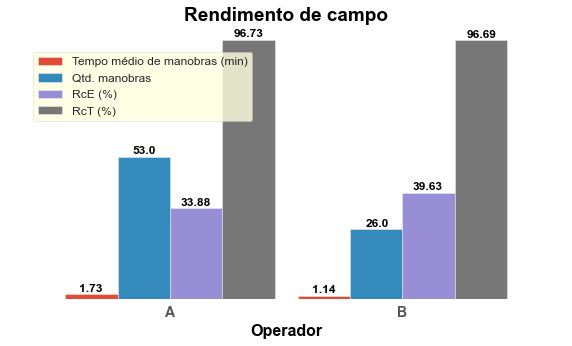

In [ ]:
#Gráfico rendimento de campo
Rendimento = round((Dados3.groupby('Operador')['Tempo médio de manobras (min)', 'Qtd. manobras', 'RcE (%)', 'RcT (%)'].mean().reset_index()),2)
Rendimento = Rendimento.set_index('Operador')

fig89 = plt.figure()
plt.style.use("ggplot")
Rendimento.plot(kind='bar', width=0.9)

for i, v in enumerate(Rendimento['RcT (%)']):
            plt.text(i  + 0.34, v + 1, str(v), color='black', ha='center', size = 12,  fontweight='bold', alpha=1)
for j, t in enumerate(Rendimento['RcE (%)']):
            plt.text(j  + 0.11, t + 1, str(t), color='black', ha='center', size = 12, fontweight='bold', alpha=1)
for g, e in enumerate(Rendimento['Qtd. manobras']):
            plt.text(g  - 0.11, e + 1, str(e), color='black', ha='center', size = 12, fontweight='bold', alpha=1)
for k, u in enumerate(Rendimento['Tempo médio de manobras (min)']):
            plt.text(k  - 0.34, u + 1, str(u), color='black', ha='center', size = 12, fontweight='bold', alpha=1)

plt.xlabel('Operador', size = 16, fontweight='bold', color='black', alpha=1)
plt.title('Rendimento de campo', fontweight='bold', size = 19, color='black', alpha=1)
plt.box(on=None)
plt.yticks([])
plt.xticks(rotation=0, fontsize=14, fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(0.45, 0.93), fontsize=12, facecolor='lightyellow')
plt.savefig('C:/Users/lfsou/OneDrive/Área de Trabalho/VSCODE/NOVO/TCC/Rendimendo de campo.png', format='png')
plt.show()

In [ ]:
# Salvando_html_doc = !Jupyter nbconvert AnáliseDados.ipynb --no-input --to html